<a href="https://colab.research.google.com/github/steelpipe75/learn-langgraph/blob/main/LangGraph%E3%81%A7%E3%81%97%E3%82%8A%E3%81%A8%E3%82%8A/LangGraph_shiritori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LangGraphでしりとり

----

ライブラリをインストール

In [1]:
!apt-get update
!apt-get install -y graphviz libgraphviz-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:9 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [2]:
!pip install langgraph pygraphviz

----

In [3]:
from google import genai
from typing_extensions import TypedDict

from IPython.display import Image, display

In [4]:
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

以下のセルを実行するには、シークレットの "GOOGLE_API_KEY" にAPIキーを保存しておく必要があります。  
GeminiのAPIキーは [Google AI Studio](https://aistudio.google.com/) の Get API Key から取得できます。

In [5]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

In [6]:
client = genai.Client(api_key=GOOGLE_API_KEY)

def gemini_reply(prompt: str) -> str:
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=prompt)
    return response.text

In [7]:
from langgraph.graph import StateGraph
import re
import json

In [8]:
# ゲームの状態
class ShiritoriState(TypedDict):
    history: list[str]
    input_word: str
    last_word: str
    user_turn: bool
    user_win: bool
    game_over: bool # ゲームが終了したかどうか

In [9]:
# ユーザー入力ステップ
def user_input_step(state: ShiritoriState):
    word = input("あなたの単語（終了（投了）は空のままエンター）: ").strip()
    state["input_word"] = word
    state["user_turn"] = True
    return state

In [10]:
# llm応答ステップ
def llm_step(state: ShiritoriState):
    prompt = f"""以下の条件に従って、しりとりの単語を1つ出してください。
- 前の単語: {state['last_word']}
- 使用済み単語: {', '.join(state['history'])}
- 「ん」で終わらないこと
- 再使用禁止

単語だけを返してください。"""

    reply = gemini_reply(prompt)
    word = re.findall(r'\w+', reply)[0]  # 最初の単語を取得
    print(f"Geminiの単語: {word}")
    state["input_word"] = word
    state["user_turn"] = False
    return state

def routing_check_user_input(state: ShiritoriState):
    if state["input_word"] == "":
        return "surrender"
    return "check_n"

In [11]:
# ===== 「ん」チェック =====

def n_end(state: ShiritoriState):
    """最後の単語が「ん」で終わった場合の処理"""
    print(f"'{state['input_word']}' は「ん」で終わったためゲームオーバーです。")
    return state

# ----- ルールベース -----

def check_n(state: ShiritoriState):
    """最後の文字が「ん」かどうかをチェックする"""
    return state

def routing_check_n(state: ShiritoriState):
    last_char = state["input_word"][-1]
    print(f"routing_check_n: last_char={last_char}")
    if last_char == "ん" or last_char == "ン":
        # print("n_end")
        return "n_end"
    else:
        # print("continue")
        return "check_n_llm"

# ----- LLM -----

def check_n_llm(state: ShiritoriState):
    return state

def routing_check_n_llm(state: ShiritoriState):
    prompt = f"""しりとりにおいて、今回の単語が「ん」で終わっているかどうかを判定してください。

【ルール】
- カタカナ、ひらがな、漢字といった表記は無視して読み方の最後の文字で判断してください。
- たとえば「饂飩」などは読み方が「うどん」なので「ん」で終わっているためNGです。

【今回の単語】：{state['input_word']}

【出力フォーマット】
次のJSON形式で出力してください：

{{
  "n_end": true,  // または false
  "reason": "ここに簡潔な理由を記述"
}}

出力例：
{{
  "n_end": true,
  "reason": "今回の単語は「公園」で読み方が「こうえん」で「ん」で終わっています。"
}}

```json 〜 ``` のようなJSONとしてパースできない装飾を出力しないでください。
"""

    print(f"prompt : {prompt}")
    print("========================================")
    reply = gemini_reply(prompt)
    print(f"reply : {reply}")
    print("========================================")
    json_match = re.search(r'\{[\s\S]*\}', reply)
    if not json_match:
        raise ValueError("JSON部分が見つかりませんでした。")

    try:
        json_str = json_match.group(0) # マッチした文字列を抽出
        print(f"json_str : {json_str}")
        print("========================================")
        result = json.loads(json_str)
        if not result["n_end"]:
            return "OK"
        else:
            print(f"{result=}")
            reason = result["reason"]
            print(f"NG : {reason}")
            return "NG"
    except json.JSONDecodeError as e:
        print(f"JSONパースエラー: {e}")
        return "NG"

In [12]:
# ===== 履歴チェック =====

def check_history(state: ShiritoriState):
    return state

def routing_check_history(state: ShiritoriState):
    if state["input_word"] in state["history"]:
        return "exist_history"
    return "check_tail_head_rule"

def exist_history(state: ShiritoriState):
    print("すでに使われた単語を出しました")
    return state

In [13]:
# ===== 末尾と頭のチェック =====

def tail_head_unmatch(state: ShiritoriState):
    print("末尾と頭が一致しません")
    return state

# ----- ルールベース -----

def check_tail_head_rule(state: ShiritoriState):
    return state

def routing_check_tail_head_rule(state: ShiritoriState):
    print(f"routing_check_tail_head : {state=}")
    if len(state["history"]) == 0:
        print("最初の順番 : turn_change")
        return "turn_change"

    last_word_tail = state["last_word"][-1]
    input_word_head = state["input_word"][0]
    print(f"{last_word_tail=}, {input_word_head=}")

    if state["last_word"][-1] != state["input_word"][0]:
        print("check_tail_head_llm")
        return "check_tail_head_llm"
    print("turn_change")
    return "turn_change"

# ----- LLM -----

def check_tail_head_llm(state: ShiritoriState):
    return state

def routing_check_tail_head_llm(state: ShiritoriState):
    prompt = f"""しりとりにおいて、前の単語と今回の単語が正しくつながっているかを判定してください。

【ルール】
- 単語の最初の文字は、前の単語の最後の文字と一致している必要があります。
- 前の単語が「ー」で終わる場合は、その直前の文字を最後とみなします。
- 「っ」「ゃ」「ょ」などは、小文字と大文字を同一視してよいです。
- カタカナ、ひらがな、漢字といった表記は無視して読み方の最後の文字で判断してください。
- たとえば「らっこ」→「コップ」などは有効。

【前の単語】：{state['last_word']}
【今回の単語】：{state['input_word']}

【出力フォーマット】
次のJSON形式で出力してください：

{{
  "valid_connection": true,  // または false
  "reason": "ここに簡潔な理由を記述"
}}

出力例：
{{
  "valid_connection": false,
  "reason": "前の単語は「りんご」で、最後の文字が「ご」なのに、今回の単語は「さかな」でつながっていません。"
}}

```json 〜 ``` のようなJSONとしてパースできない装飾を出力しないでください。
"""

    print(f"prompt : {prompt}")
    print("========================================")
    reply = gemini_reply(prompt)
    print(f"reply : {reply}")
    print("========================================")
    json_match = re.search(r'\{[\s\S]*\}', reply)
    if not json_match:
        raise ValueError("JSON部分が見つかりませんでした。")

    try:
        json_str = json_match.group(0) # マッチした文字列を抽出
        print(f"json_str : {json_str}")
        print("========================================")
        result = json.loads(json_str)
        if result["valid_connection"]:
            return "OK"
        else:
            print(f"{result=}")
            reason = result["reason"]
            print(f"NG : {reason}")
            return "NG"
    except json.JSONDecodeError as e:
        print(f"JSONパースエラー: {e}")
        return "NG"

In [14]:
# ===== 手番変更処理 =====

def turn_change(state: ShiritoriState):
    word = state["input_word"]
    state["history"].append(word)
    state["last_word"] = word
    state["input_word"] = ""
    return state

In [15]:
# ===== 次プレイヤーへの遷移 =====

def routing_next_player(state: ShiritoriState):
    if state["user_turn"]:
        return "llm_response"
    return "user_input"

In [16]:
# ===== 降参 =====

def surrender(state: ShiritoriState):
    print("投了")
    return state

In [17]:
# ===== 勝敗表示 =====

def routing_win_lose(state: ShiritoriState):
    if state["user_turn"]:
        return "lose"
    return "win"

def lose_user(state: ShiritoriState):
    print("あなたの負けです")
    return {"user_win": False, "game_over": True}

def win_user(state: ShiritoriState):
    print("あなたの勝ちです")
    return {"user_win": True, "game_over": True}

In [18]:
# ===== 次のターン =====

def next_user_input(state: ShiritoriState):
    return state

In [19]:
# LangGraphのグラフ構築
builder = StateGraph(ShiritoriState)

builder.add_node("user_input", user_input_step)
builder.add_node("llm_response", llm_step)

builder.add_node("check_n", check_n)
builder.add_node("check_n_llm", check_n_llm)
builder.add_node("n_end", n_end)

builder.add_node("check_history", check_history)
builder.add_node("exist_history", exist_history)

builder.add_node("check_tail_head_rule", check_tail_head_rule)
builder.add_node("check_tail_head_llm", check_tail_head_llm)
builder.add_node("tail_head_unmatch", tail_head_unmatch)

builder.add_node("turn_change", turn_change)
builder.add_node("surrender", surrender)
builder.add_node("lose", lose_user)
builder.add_node("win", win_user)
builder.add_node("next_user_input", next_user_input)

builder.set_entry_point("user_input")
builder.set_finish_point("lose")
builder.set_finish_point("win")
builder.set_finish_point("next_user_input")

builder.add_conditional_edges(
    source="user_input",
    path=routing_check_user_input,
    path_map={"surrender": "surrender", "check_n": "check_n"},
)

builder.add_conditional_edges(
    source="check_n",
    path=routing_check_n,
    path_map={"n_end": "n_end", "check_n_llm": "check_n_llm"},
)
builder.add_conditional_edges(
    source="check_n_llm",
    path=routing_check_n_llm,
    path_map={"NG": "n_end", "OK": "check_history"},
)
builder.add_conditional_edges(
    source="check_history",
    path=routing_check_history,
    path_map={"exist_history": "exist_history", "check_tail_head_rule": "check_tail_head_rule"},
)
builder.add_conditional_edges(
    source="check_tail_head_rule",
    path=routing_check_tail_head_rule,
    path_map={"check_tail_head_llm": "check_tail_head_llm", "turn_change": "turn_change"},
)
builder.add_conditional_edges(
    source="check_tail_head_llm",
    path=routing_check_tail_head_llm,
    path_map={"NG": "tail_head_unmatch", "OK": "turn_change"},
)

builder.add_conditional_edges(
    source="n_end",
    path=routing_win_lose,
    path_map={"lose": "lose", "win": "win"},
)
builder.add_conditional_edges(
    source="exist_history",
    path=routing_win_lose,
    path_map={"lose": "lose", "win": "win"},
)
builder.add_conditional_edges(
    source="tail_head_unmatch",
    path=routing_win_lose,
    path_map={"lose": "lose", "win": "win"},
)

builder.add_conditional_edges(
    source="turn_change",
    path=routing_next_player,
    path_map={"llm_response": "llm_response", "user_input": "next_user_input"},
)

builder.add_edge("llm_response", "check_history")

builder.add_edge("surrender", "lose")

graph = builder.compile()

In [20]:
mermaid_str = graph.get_graph().draw_mermaid()
print(mermaid_str)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	user_input(user_input)
	llm_response(llm_response)
	check_n(check_n)
	check_n_llm(check_n_llm)
	n_end(n_end)
	check_history(check_history)
	exist_history(exist_history)
	check_tail_head_rule(check_tail_head_rule)
	check_tail_head_llm(check_tail_head_llm)
	tail_head_unmatch(tail_head_unmatch)
	turn_change(turn_change)
	surrender(surrender)
	lose(lose)
	win(win)
	next_user_input(next_user_input)
	__end__([<p>__end__</p>]):::last
	__start__ --> user_input;
	check_history -.-> check_tail_head_rule;
	check_history -.-> exist_history;
	check_n -.-> check_n_llm;
	check_n -.-> n_end;
	check_n_llm -. &nbsp;OK&nbsp; .-> check_history;
	check_n_llm -. &nbsp;NG&nbsp; .-> n_end;
	check_tail_head_llm -. &nbsp;NG&nbsp; .-> tail_head_unmatch;
	check_tail_head_llm -. &nbsp;OK&nbsp; .-> turn_change;
	check_tail_head_rule -.-> check_tail_head_llm;
	check_tail_head_rule -.-> turn_change;
	exist_history -.-> lo

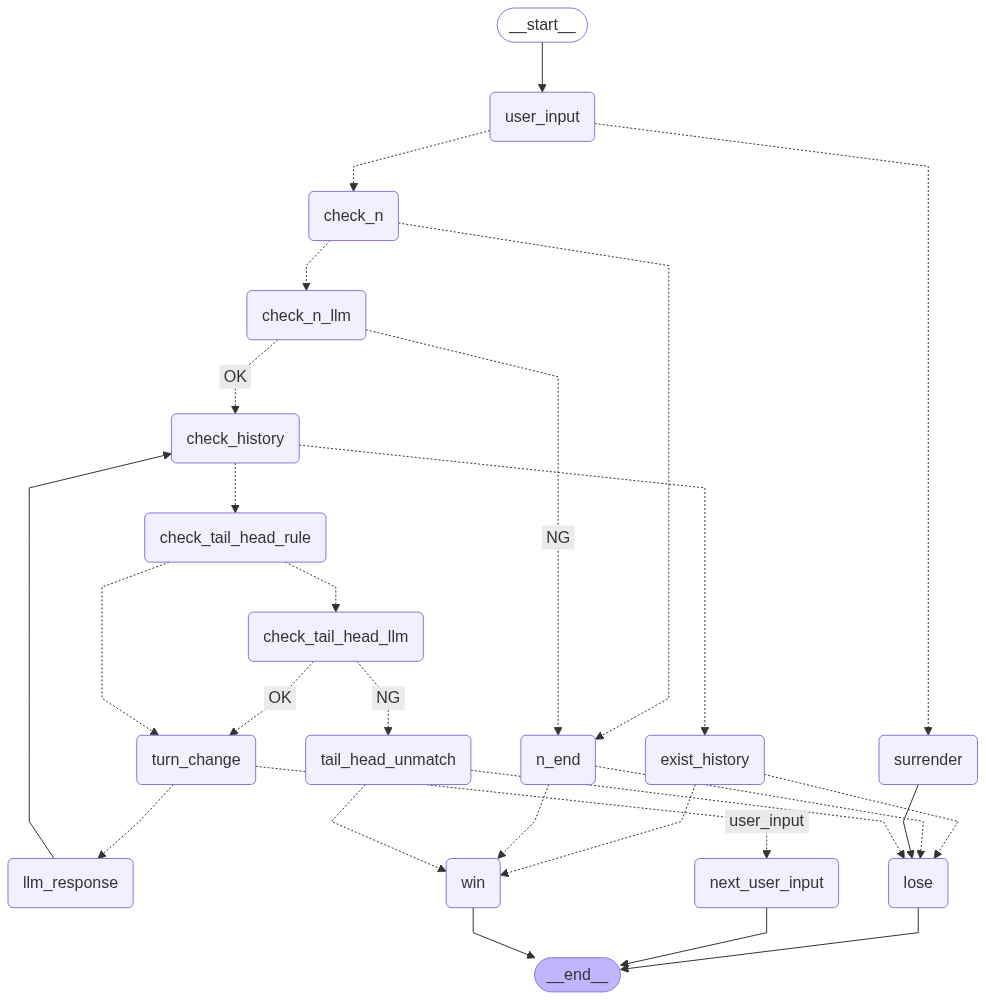

In [21]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"グラフの描画中にエラーが発生しました: {e}") # 描画中に発生したエラーを出力する
    pass

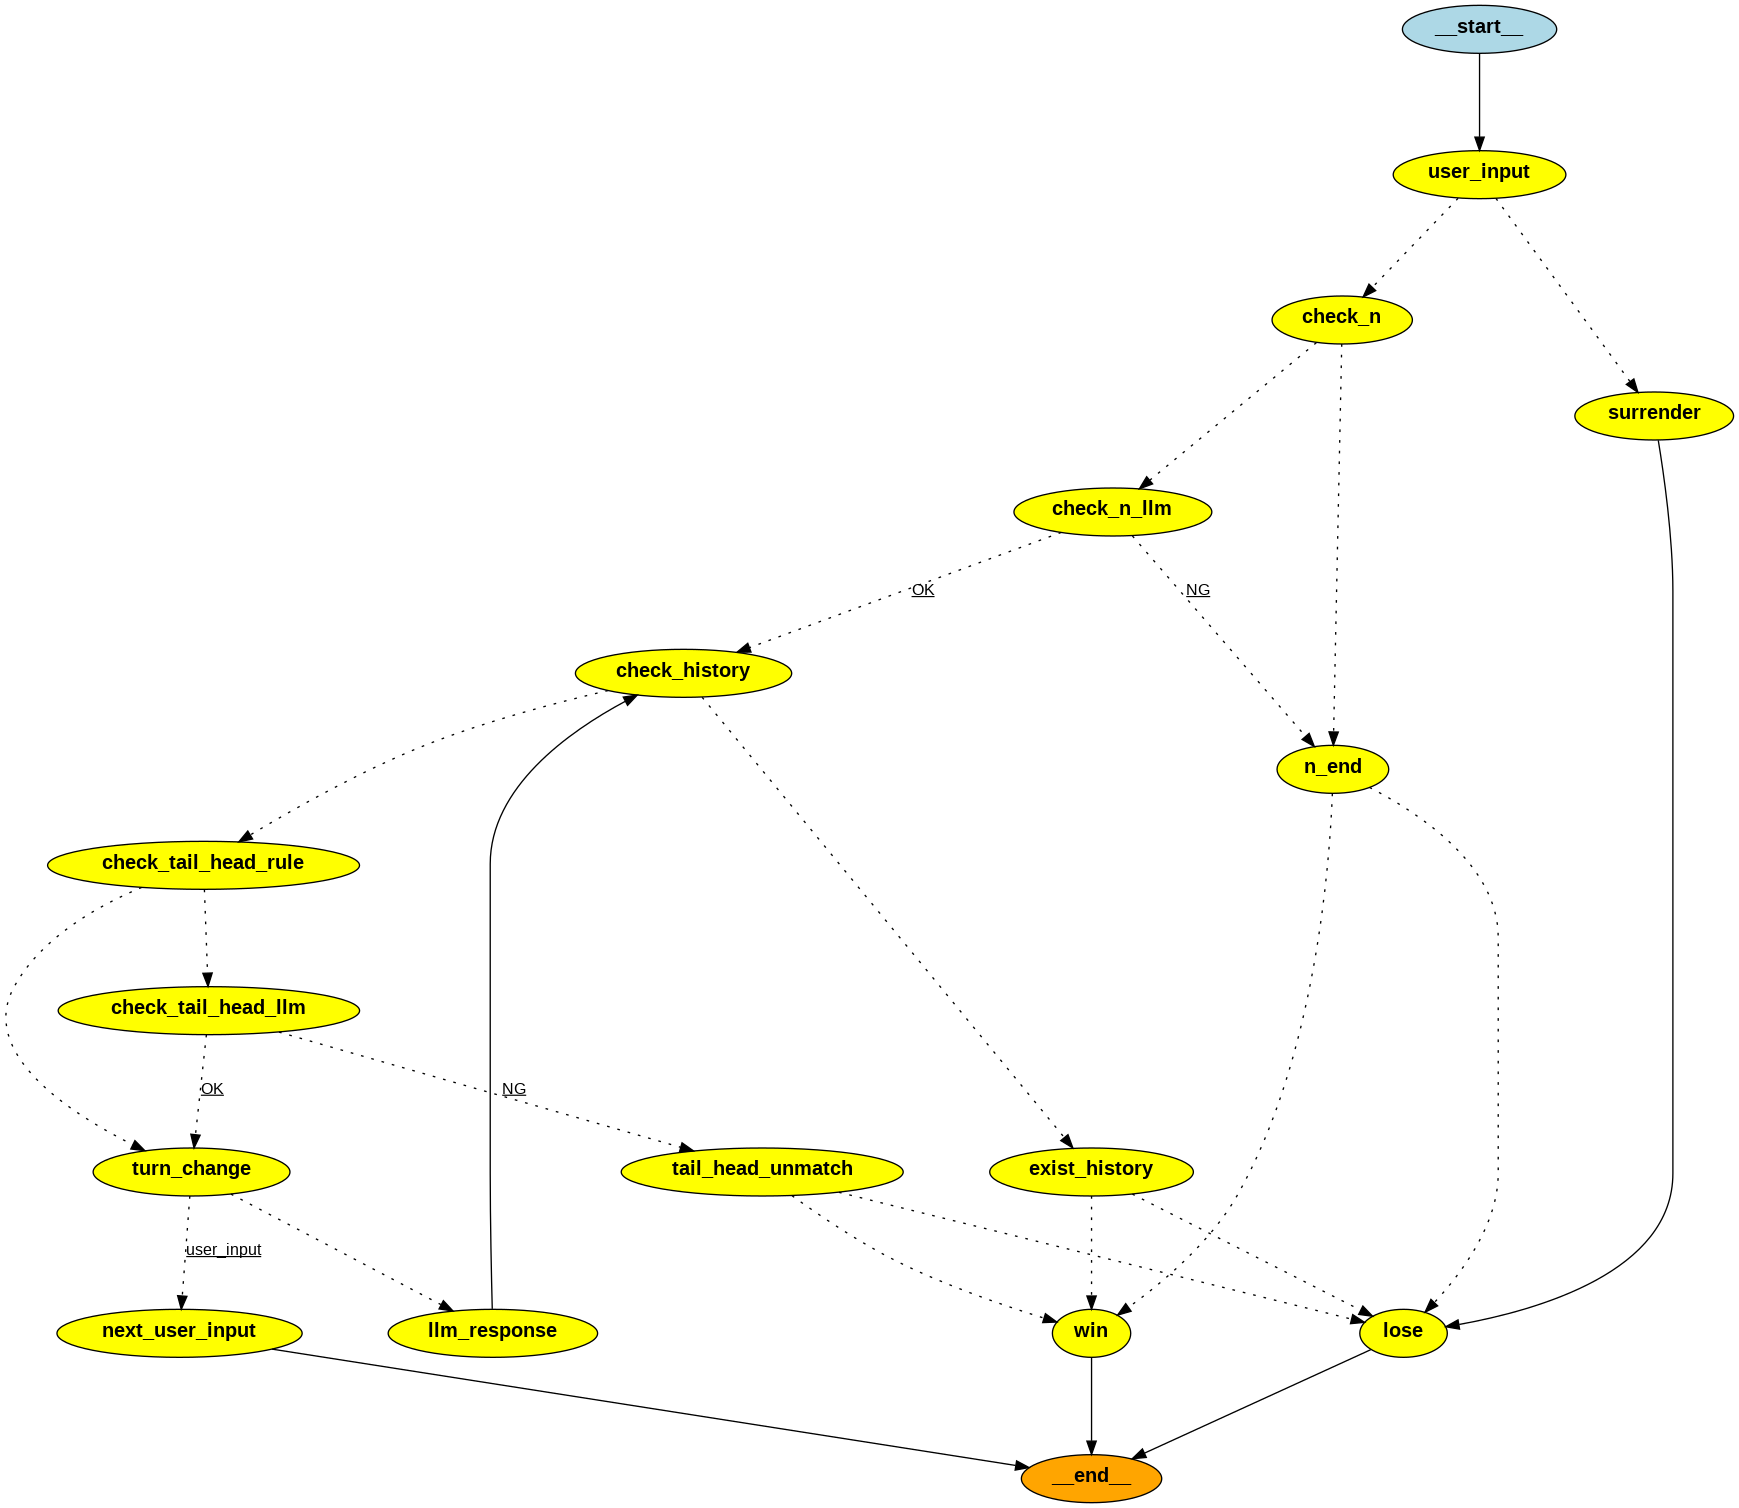

In [22]:
try:
    display(Image(graph.get_graph().draw_png()))
except Exception as e:
    print(f"グラフの描画中にエラーが発生しました: {e}") # 描画中に発生したエラーを出力する
    pass

In [23]:
# 初期状態
state = ShiritoriState({"history": [], "last_word": "", "game_over": False})
config = {"recursion_limit": 20}

while not state["game_over"]:
    state = graph.invoke(state, config=config, debug=True)

[values] {'history': [], 'last_word': '', 'game_over': False}
あなたの単語（終了（投了）は空のままエンター）: リンゴ
[updates] {'user_input': {'history': [], 'last_word': '', 'game_over': False, 'input_word': 'リンゴ', 'user_turn': True}}
[values] {'history': [], 'input_word': 'リンゴ', 'last_word': '', 'user_turn': True, 'game_over': False}
routing_check_n: last_char=ゴ
[updates] {'check_n': {'history': [], 'input_word': 'リンゴ', 'last_word': '', 'user_turn': True, 'game_over': False}}
[values] {'history': [], 'input_word': 'リンゴ', 'last_word': '', 'user_turn': True, 'game_over': False}
prompt : しりとりにおいて、今回の単語が「ん」で終わっているかどうかを判定してください。

【ルール】
- カタカナ、ひらがな、漢字といった表記は無視して読み方の最後の文字で判断してください。
- たとえば「饂飩」などは読み方が「うどん」なので「ん」で終わっているためNGです。

【今回の単語】：リンゴ

【出力フォーマット】
次のJSON形式で出力してください：

{
  "n_end": true,  // または false
  "reason": "ここに簡潔な理由を記述"
}

出力例：
{
  "n_end": true,
  "reason": "今回の単語は「公園」で読み方が「こうえん」で「ん」で終わっています。"
}

```json 〜 ``` のようなJSONとしてパースできない装飾を出力しないでください。

reply : ```json
{
  "n_end": false,
  "reason": "今回の単語は「リンゴ」で読み方が「